In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

cb_fc_ec information of 067-2 not given.


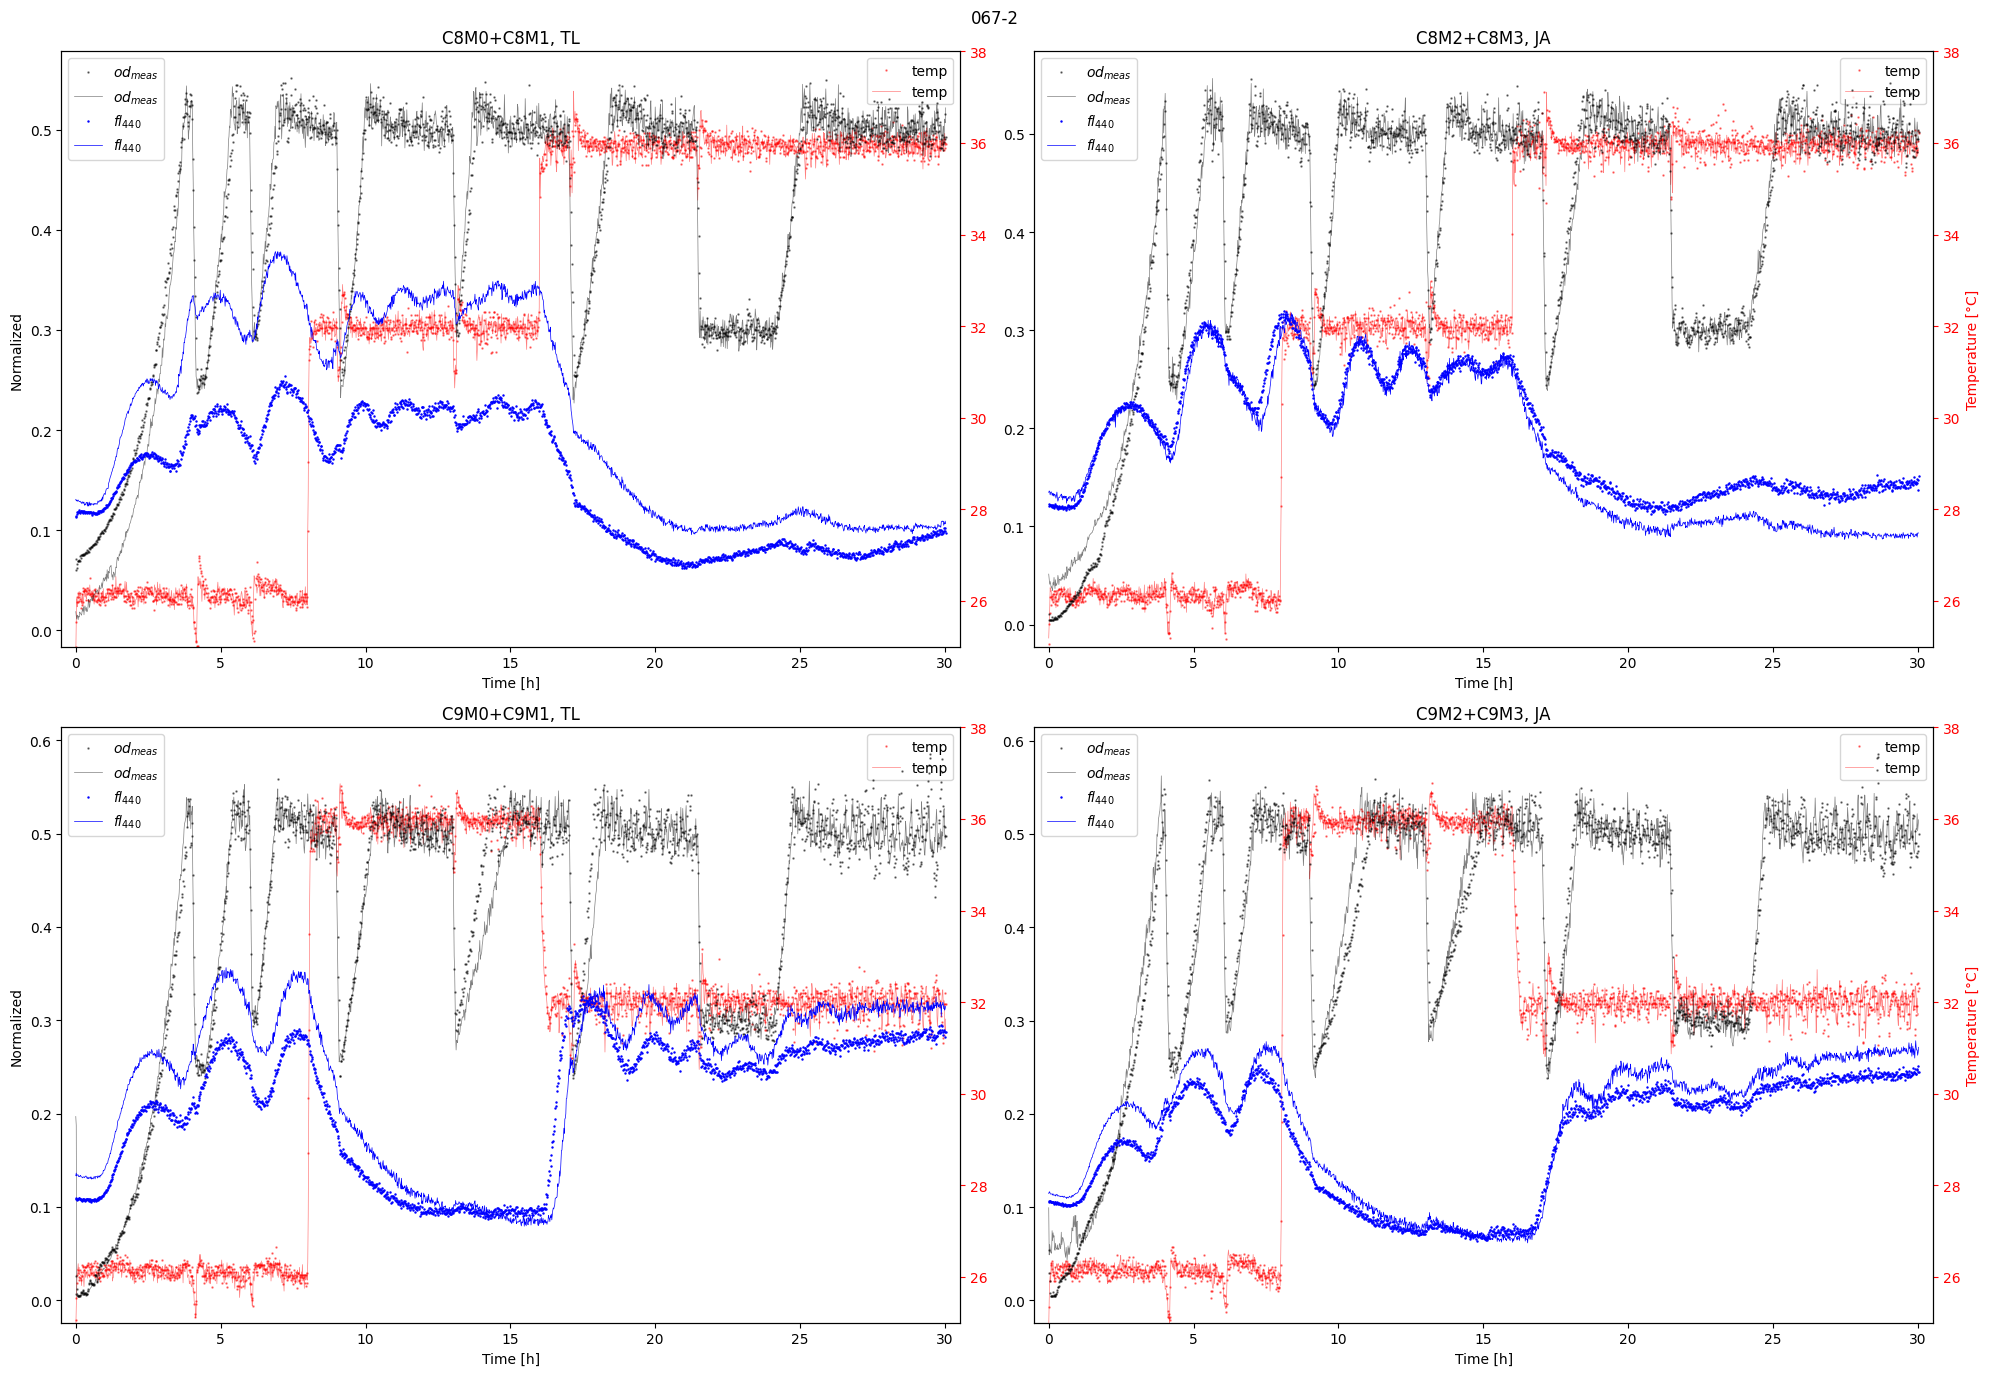

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from run import CbData
from paramsData import CbDataParam
from params import Params
import os

# SPECIFY DATA
data_name = '067-2'
cbParam = CbDataParam(data_name)
# cbParam.sampcycle = np.array([[0,1800] for i in range(cbParam.n_reactors)])
cbData = CbData(cbParam.path, cbParam.file_ind, cbParam.sampcycle, cbParam.n_reactors)

parameters = Params().default

# ANALYSIS
cbParam.n_reactors = 4
cbParam.titles = ['C8M0+C8M1, TL', '', 'C8M2+C8M3, JA', '', 'C9M0+C9M1, TL' , '','C9M2+C9M3, JA']
b1_max = max(max(cbData.b1[j]) for j in range(cbParam.n_reactors))
e1_max = max(max(cbData.b1[j]*cbData.fl[j]) for j in range(cbParam.n_reactors))
n_rows = math.ceil(cbParam.n_reactors/2)
n_culumns = 2 if cbParam.n_reactors > 1 else 1
matplotlib.style.use('default')
fig, ax = plt.subplots(n_rows,n_culumns)
fig.set_figheight(n_rows*7)
fig.set_figwidth(n_culumns*10)
if n_culumns == 1:
    ax = [ax]
if n_rows == 1:
    ax = [ax]
for j in range(cbParam.n_reactors):
    r = j//2
    c = j%2
    # j = 1
    j *= 2

    axr = ax[r][c].twinx()
    ax[r][c].set_zorder(2)
    axr.set_zorder(1)
    ax[r][c].patch.set_visible(False)

    axr.plot(cbData.time_h[j],cbData.temp[j],'.r',markersize = 1.5, alpha=0.5, label = 'temp')
    axr.plot(cbData.time_h[j+1],cbData.temp[j+1],'r',lw=0.5, alpha=0.5, label = 'temp')
    # axr.plot(cbData.time_h[j],cbData.temp_sp[j],'r',lw=0.5, alpha=1, label = 'temp_sp')
    # axr.plot(cbData.time_h[j],cbData.temp_ext[j],'b',lw=0.5, alpha=1, label = 'temp_ext')
    # axr.plot(cbData.time_h[j],cbData.temp_int[j],'m',lw=0.5, alpha=1, label = 'temp_int')
    # ax[r][c].plot(cbData.time_h[j],cbData.hr[j]*100,'k',lw=0.5, alpha=0.5, label = '$hr_{meas}*100$')
    ax[r][c].plot(cbData.time_h[j],cbData.od[j],'.k', markersize = 1.5, alpha=0.5, label = '$od_{meas}$')
    ax[r][c].plot(cbData.time_h[j+1],cbData.od[j+1],'k', lw=0.5, alpha=0.5, label = '$od_{meas}$')
    # ax[r][c].plot(cbData.time_h[j],cbData.fl[j]*cbData.b1[j]/e1_max,'.g',markersize = 1.5, label = '$e1_{meas,norm}$')
    ax[r][c].plot(cbData.time_h[j],cbData.fl[j],'.', color = '#0000ff',markersize = 1.5, alpha = 1, label = '$fl_{440}$')
    ax[r][c].plot(cbData.time_h[j+1],cbData.fl[j+1], color = '#0000ff',lw = 0.5, alpha = 1, label = '$fl_{440}$')
    
    ax[r][c].legend(loc="upper left",)
    axr.legend(loc="upper right")
    # axr.legend(loc="upper right")
    if (c == 0):
        ax[r][c].set_ylabel("Normalized")
    else:
        axr.set_ylabel('Temperature [°C]', color='r')
        ax[r][c].tick_params(axis='y', labelleft=True)
    axr.tick_params(axis='y', color='r', labelcolor='r')
    ax[r][c].set_xlabel("Time [h]")
    ax[r][c].set_xlim([cbData.time_h[j][0]-0.5,cbData.time_h[j][-1]+0.5])
    # ax[r][c].set_ylim([-5,105])
    axr.set_ylim([25,38])
    ax[r][c].set_title(cbParam.titles[j])
# TODO: Set titles
fig.suptitle(data_name)
fig.tight_layout()
results_dir = "Images/{}".format(data_name)
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir+"/analysis_fl_comp.png",transparent=True)

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from paramsData import CbDataParam
import os
import glob
import pandas as pd

class CbData:
    def __init__(self, cbParam, data_name):
        cb_files = sorted(glob.glob(cbParam.path + "/*.csv"))
        cb_dfs = []
        for i in cbParam.file_ind:
            df = pd.read_csv(cb_files[i], index_col=None, header=0)
            cb_dfs.append(df)

        self.time, self.time_h, self.temp, self.fl_440, self.fl_470, self.b1 = [], [], [], [], [], []
        self.a410, self.a440, self.a470, self.a510, self.a550, self.aClear = [], [], [], [], [], []
        for j in range(cbParam.n_reactors):
            time = cb_dfs[j]["exp_time"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy()
            self.time.append(time-time[0])
            self.time_h.append(self.time[j]/3600)
            self.temp.append(cb_dfs[j]["media_temp"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
            self.fl_440.append(cb_dfs[j]["FP1_emit1"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
            self.fl_470.append(cb_dfs[j]["FP1_emit2"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
            self.b1.append(cb_dfs[j]["FP1_base"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
            if data_name == '051-1':
                if (j < 4):
                    self.a410.append(cb_dfs[j]["LEDA_410"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a440.append(cb_dfs[j]["LEDA_440"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a470.append(cb_dfs[j]["LEDA_470"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a510.append(cb_dfs[j]["LEDA_510"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a550.append(cb_dfs[j]["LEDA_550"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.aClear.append(cb_dfs[j]["LEDA_CLEAR"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                else:
                    self.a410.append(cb_dfs[j]["Em_nm410_Ex_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a440.append(cb_dfs[j]["Em_nm440_Ex_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a470.append(cb_dfs[j]["Em_nm470_Ex_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a510.append(cb_dfs[j]["Em_nm510_Ex_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.a550.append(cb_dfs[j]["Em_nm550_Ex_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                    self.aClear.append(cb_dfs[j]["Em_CLEAR_Ex_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
            else:
                self.a410.append(cb_dfs[j]["Em_nm410_Ex_395_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                self.a440.append(cb_dfs[j]["Em_nm410_Ex_457_LEDB"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                self.a470.append(cb_dfs[j]["Em_nm410_Ex_500_LEDC"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                self.a510.append(cb_dfs[j]["Em_nm410_Ex_523_LEDD"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                self.a550.append(cb_dfs[j]["Em_nm410_Ex_595_LEDE"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
                self.aClear.append(cb_dfs[j]["Em_nm440_Ex_395_LEDA"][cbParam.sampcycle[j][0]:cbParam.sampcycle[j][-1]+1].to_numpy())
            

# SPECIFY DATA
data_name = '067-2'
cbParam = CbDataParam(data_name)
cbData = CbData(cbParam, data_name)

# ANALYSIS
# cbParam.n_reactors = 1
n_rows = math.ceil(cbParam.n_reactors/2)
n_culumns = 2 if cbParam.n_reactors > 1 else 1
matplotlib.style.use('default')
fig, ax = plt.subplots(n_rows,n_culumns,sharey='all')
fig.set_figheight(n_rows*7)
fig.set_figwidth(n_culumns*10)
if n_culumns == 1:
    ax = [ax]
if n_rows == 1:
    ax = [ax]
for j in range(cbParam.n_reactors):
    r = j//2
    c = j%2

    axr = ax[r][c].twinx()
    ax[r][c].set_zorder(2)
    axr.set_zorder(1)
    ax[r][c].patch.set_visible(False)

    # axr.plot(cbData.time_h[j],cbData.temp[j],'--r',lw=0.5, alpha=0.5)
    # axr.plot(cbData.time_h[j],cbData.a410[j]/cbData.aClear[j],color='#7e00db',lw=1, alpha=1, label = '410/clear')
    # axr.plot(cbData.time_h[j],cbData.a440[j]/cbData.aClear[j],color='#0000ff',lw=1, alpha=1, label = '440/clear')
    # axr.plot(cbData.time_h[j],cbData.a470[j]/cbData.aClear[j],color='#00a9ff',lw=1, alpha=1, label = '470/clear')
    # axr.plot(cbData.time_h[j],cbData.a510[j]/cbData.aClear[j],color='#00ff00',lw=1, alpha=1, label = '510/clear')
    # axr.plot(cbData.time_h[j],cbData.a550[j]/cbData.aClear[j],color='#a3ff00',lw=1, alpha=1, label = '550/clear')
    # axr.plot(cbData.time_h[j],cbData.fl_440[j],'.', color = '#0000ff',markersize = 0.5, alpha = 1, label = '$fl_{440}$')
    # axr.plot(cbData.time_h[j],cbData.fl_470[j],'.', color = '#00a9ff',markersize = 0.5, alpha = 1, label = '$fl_{470}$')

    # ax[r][c].plot(cbData.time_h[j],cbData.b1[j],'k',lw=.5, alpha=1, label = 'b1')
    # ax[r][c].plot(cbData.time_h[j],cbData.fl_440[j]*cbData.b1[j], color = '#0000ff',lw = 0.5, alpha = 1, label = '$fl_{440}$')
    # ax[r][c].plot(cbData.time_h[j],cbData.fl_470[j]*cbData.b1[j], color = '#00a9ff',lw = 0.5, alpha = 1, label = '$fl_{470}$')
    ax[r][c].plot(cbData.time_h[j],cbData.a410[j],'.',color='#7e00db',markersize=.5, alpha=1, label = '410')
    ax[r][c].plot(cbData.time_h[j],cbData.a440[j],'.',color='#0000ff',markersize=.5, alpha=1, label = '440')
    # ax[r][c].plot(cbData.time_h[j],cbData.a470[j],'.',color='#00a9ff',markersize=.5, alpha=1, label = '470')
    # ax[r][c].plot(cbData.time_h[j],cbData.a510[j],'.',color='#00ff00',markersize=.5, alpha=1, label = '510')
    # ax[r][c].plot(cbData.time_h[j],cbData.a550[j],'.',color='#a3ff00',markersize=.5, alpha=1, label = '550')
    ax[r][c].plot(cbData.time_h[j],cbData.aClear[j],'.k', markersize=.5, alpha=1, label = 'Clear')

    ax[r][c].legend(loc="upper left")
    if (j%2 == 0):
        ax[r][c].set_ylabel("Intensity at emission band wavelength")
    else:
        axr.set_ylabel('Relative intensity at emission band wavelength')
        ax[r][c].tick_params(axis='y', labelleft=True)
    ax[r][c].set_xlabel("Time [h]")
    ax[r][c].set_xlim([cbData.time_h[j][0]-0.5,cbData.time_h[j][-1]+0.5])
    # axr.set_ylim([0,0.35])
    # axr.set_ylim([25,38])
    ax[r][c].set_title(cbParam.titles[j])
# TODO: Set titles
fig.suptitle(data_name)
fig.tight_layout()
results_dir = "Images/{}".format(data_name)
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir+"/analysis_spec.png",transparent=True)
plt.close()

cb_fc_ec information of 067-2 not given.


In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from run import CbData
from paramsData import CbDataParam
from config.params import Params
import os

# SPECIFY DATA
data_name = '075-1'
cbParam = CbDataParam(data_name)
sampcycle = cbParam.sampcycle.copy()
cbParam.sampcycle = np.array([[0,1800] for i in range(cbParam.n_reactors)])
# cbParam.sampcycle = np.array([[0,2700] for i in range(cbParam.n_reactors)])
# cbParam.sampcycle = np.array([[0,2500] for i in range(cbParam.n_reactors)])
cbData = CbData(cbParam.path, cbParam.file_ind, cbParam.sampcycle, cbParam.n_reactors)
parameters = Params().default
# ANALYSIS
b1_max = max(max(cbData.b1[j]) for j in range(cbParam.n_reactors))
e = [(cbData.b1[j]*cbData.fl[j] - parameters['e_ofs'][cbParam.reactors[j]])/parameters['e_fac'][cbParam.reactors[j]] + parameters['e_ofs'][cbParam.reactors[j]] for j in range(cbParam.n_reactors)]
e1_max = max(max(e[j]) for j in range(cbParam.n_reactors))
print(e1_max)
# cbParam.n_reactors = 2
n_rows = math.ceil(cbParam.n_reactors/2)
n_culumns = 2 if cbParam.n_reactors > 1 else 1
matplotlib.style.use('default')
fig, ax = plt.subplots(n_rows,n_culumns,sharey='all')
fig.set_figheight(n_rows*7)
fig.set_figwidth(n_culumns*10)
if n_culumns == 1:
    ax = [ax]
if n_rows == 1:
    ax = [ax]
for j in range(cbParam.n_reactors):
# for j in [0,7]:
    r = j//2
    c = j%2
    # if j == 7:
    #     r = 0
    #     c = 1

    axr = ax[r][c].twinx()
    ax[r][c].set_zorder(2)
    axr.set_zorder(1)
    ax[r][c].patch.set_visible(False)

    axr.plot(cbData.time_h[j],cbData.temp[j],'.-r',markersize = 1.5, lw = 1, alpha=0.5, label = 'temp')

    ax[r][c].plot(cbData.time_h[j],cbData.od[j],'.k', markersize = 1.5, alpha=0.5, label = '$od_{meas}$')
    ax[r][c].plot(cbData.time_h[j],cbData.fl[j]*cbData.b1[j]/e1_max,'.g',markersize = 1.5, alpha = 0.5, label = '$e_{meas,norm}$')
    ax[r][c].plot(cbData.time_h[j],e[j]/e1_max,'.g',markersize = 1.5, label = '$e_{meas,norm}$')
    # ax[r][c].plot(cbData.time_h[j],cbData.b1[j]/b1_max,'.k',markersize = 1.5, label = '$b_{meas,norm}$')
    # ax[r][c].plot(cbData.time_h[j],cbData.fl[j],'.b',markersize = 1.5, label = '$fl_{meas}$')
    # ax[r][c].plot(cbData.time_h[j][sampcycle[j]],(100-cbParam.cb_fc_ec[j])/100.0,'xk',markersize = 10, label = '$p_{fc}$')
    
    ax[r][c].legend(loc="upper left")
    axr.legend(loc="upper right")
    # axr.legend(loc="upper right")
    if (j%2 == 0):
        ax[r][c].set_ylabel("Normalized")
    else:
        axr.set_ylabel('Temperature [°C]', color='r')
        ax[r][c].tick_params(axis='y', labelleft=True)
    axr.tick_params(axis='y', color='r', labelcolor='r')
    ax[r][c].set_xlabel("Time [h]")
    ax[r][c].set_xlim([cbData.time_h[j][0]-0.5,cbData.time_h[j][-1]+0.5])
    ax[r][c].set_ylim([0,1])
    axr.set_ylim([25,38])
    ax[r][c].set_title(cbParam.titles[j])
# TODO: Set titles
fig.suptitle(data_name)
fig.tight_layout()
results_dir = "Images/{}".format(data_name)
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir+"/analysis_fl.png",transparent=True)
# Do not show plot
plt.close()

cb_fc_ec information of 075-1 not given.


10846.344922132044


In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from run import CbData
from paramsData import CbDataParam
from config.params import Params
import os

# SPECIFY DATA
data_name = '069-4'
cbParam = CbDataParam(data_name)
sampcycle = cbParam.sampcycle.copy()
cbParam.sampcycle = np.array([[0,1800] for i in range(cbParam.n_reactors)])
cbData = CbData(cbParam.path, cbParam.file_ind, cbParam.sampcycle, cbParam.n_reactors)
parameters = Params().default

e_ofs = [parameters['e_ofs'][cbParam.reactors[j]] for j in range(cbParam.n_reactors)]
e_fac = [parameters['e_fac'][cbParam.reactors[j]] for j in range(cbParam.n_reactors)]
e = [(cbData.fl[j]*cbData.b1[j] - e_ofs[j])/e_fac[j] + e_ofs[j] for j in range(cbParam.n_reactors)]
e_max = max(max(e[j]) for j in range(cbParam.n_reactors))

pr_rec = [[] for i in range(cbParam.n_reactors)]
gr_rec = [[] for i in range(cbParam.n_reactors)]
time_h_rec = [[] for i in range(cbParam.n_reactors)]
for j in range(cbParam.n_reactors):
    time_h_list = []
    od_list = []
    dfl_list = []
    time_h = []
    gr_fit = []
    for i in range(len(cbData.time[j])):
        if cbData.dil[j][i] and not cbData.dil[j][max(0,i-1)]:
            dfl_list.append(e[j][i] - cbData.od[j][i]*parameters['od_fac'])
            od_list.append(cbData.od[j][i])
            time_h_list.append(cbData.time_h[j][i])

            p_ln_fit = np.polyfit(time_h_list-time_h_list[0], np.log(od_list), 1, w = np.sqrt(od_list)) # fit exponential, adjusted weight to account for transformation
            mu = p_ln_fit[0]
            gr_rec[j].append(mu)

            p0 = np.exp(p_ln_fit[1])
            dp_list = p0/mu*(np.exp(mu*np.array(time_h_list-time_h_list[0]))-1)# integrate exp
            pr_rec[j].append(np.polyfit(dp_list,dfl_list,1)[0])
            time_h_rec[j].append(np.mean(time_h_list))

            dfl_list = []
            time_h_list = []
            od_list = []
        if not cbData.dil[j][i]:
            if cbData.time_h[j][i] and cbData.od[j][i] > 0.006:
                dfl_list.append(e[j][i] - cbData.od[j][i]*parameters['od_fac'])
                od_list.append(cbData.od[j][i])
                time_h_list.append(cbData.time_h[j][i])

matplotlib.style.use('default')
n_rows = math.ceil(cbParam.n_reactors/2)
n_culumns = 2 if cbParam.n_reactors > 1 else 1
fig, ax = plt.subplots(n_rows,2,sharex='all',sharey='all')
fig.set_figheight(n_rows*7)
fig.set_figwidth(n_culumns*10)
if n_culumns == 1:
    ax = [ax]
if n_rows == 1:
    ax = [ax]
for j in range(cbParam.n_reactors):
    r = j//2
    c = j%2
    axr = ax[r][c].twinx()
    ax[r][c].set_zorder(2)
    axr.set_zorder(1)
    ax[r][c].patch.set_visible(False)

    axr.plot(cbData.time_h[j],cbData.temp[j],'r',lw=0.5, alpha = 0.2)
    ax[r][c].plot(cbData.time_h[j],cbData.od[j],'k',lw = 0.5, alpha = 0.2, label = 'od')
    ax[r][c].plot(cbData.time_h[j],e[j]/e_max,'.',color='#0000FF',markersize = 1, alpha = 0.4, label = 'e')
    ax[r][c].plot(time_h_rec[j],gr_rec[j]/max([max(gr_rec[m]) for m in range(cbParam.n_reactors)]),'--x',color='k',markersize = 6, label = 'bac gr')
    ax[r][c].plot(time_h_rec[j],pr_rec[j]/max([max(pr_rec[m]) for m in range(cbParam.n_reactors)]),'--x',color='#0000FF',markersize = 6, label = 'fp pr')

    ax[r][c].legend(loc="upper left")
    if (c == 0):
        axr.set_ylabel("Rate")
    else:
        axr.set_ylabel('Temperature [°C]', color='r')
        ax[r][c].tick_params(axis='y', labelleft=True)
    if r == n_rows-1:
        ax[r][c].set_xlabel("Time [h]")
    axr.tick_params(axis='y', color='r', labelcolor='r')
    ax[r][c].set_xlim([cbData.time_h[j][0]-0.5,cbData.time_h[j][-1]+0.5])
    ax[r][c].set_ylim([0,1.05])
    axr.set_ylim([28,37])
    ax[r][c].set_title(cbParam.titles[j])
fig.suptitle(data_name)
fig.tight_layout()
results_dir = "Images/{}".format(data_name)
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir + "/gr_and_pr.png",transparent=True)
# Do not show plot
plt.close()

cb_fc_ec information of 069-4 not given.


/var/folders/rm/n2qcx4x93h38srcvnc91v39w0000gn/T/ipykernel_4778/1456552342.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)


Text(0.5, 1.0, 'OD offsets for 070-1 and 075-1')

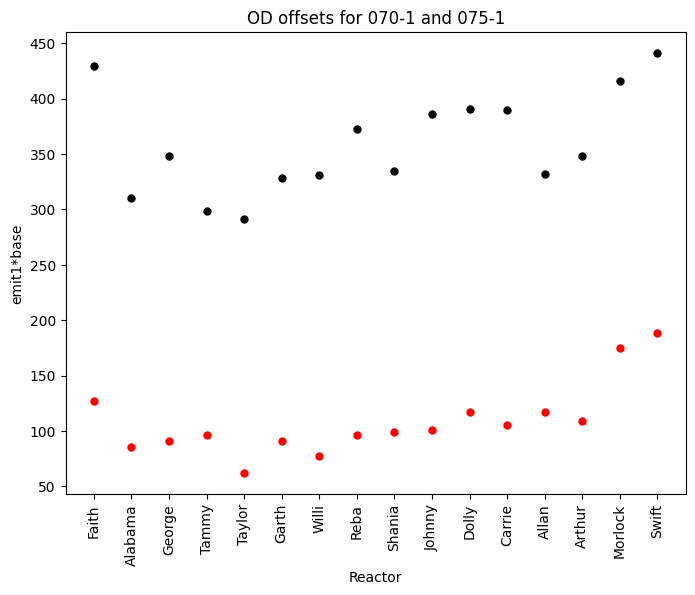

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

x = ["Faith", "Alabama", "George", "Tammy", "Taylor", "Garth", "Willi", "Reba", "Shania", "Johnny", "Dolly", "Carrie", "Allan", "Arthur", "Morlock", "Swift"]
data070 = np.array([0.136*3159,0.106*2927,0.118*2948,0.107*2788,0.087*3353,0.135*2430,0.121*2737,0.125*2981,0.117*2861,0.133*2906,0.099*3944,0.111*3515,0.107*3104,0.131*2660,0.120*3470,0.118*3739])
data075 = np.array([1784*0.071,1743*0.049,1660*0.055,1894*0.051,1935*0.032,1522*0.06,1487*0.052,1723*0.056,1797*0.055,1599*0.063,2244*0.052,1845*0.057,1852*0.063,1623*0.067,2326*0.075,2299*0.082])
# data070 = np.array([0.136,0.106,0.118,0.107,0.087,0.135,0.121,0.125,0.117,0.133,0.099,0.111,0.107,0.131,0.120,0.118])
# data075 = np.array([0.071,0.049,0.055,0.051,0.032,0.06,0.052,0.056,0.055,0.063,0.052,0.057,0.063,0.067,0.075,0.082])

matplotlib.style.use('default')
fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
ax.plot(x,data070,'.k',markersize = 10, label = '070-1')
ax.plot(x,data075,'.r',markersize = 10, label = '075-1')
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("emit1*base")
ax.set_xlabel("Reactor")
ax.set_title("OD offsets for 070-1 and 075-1")



/var/folders/rm/n2qcx4x93h38srcvnc91v39w0000gn/T/ipykernel_4778/1598711973.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)


Text(0.5, 1.0, 'Reactor fl factor')

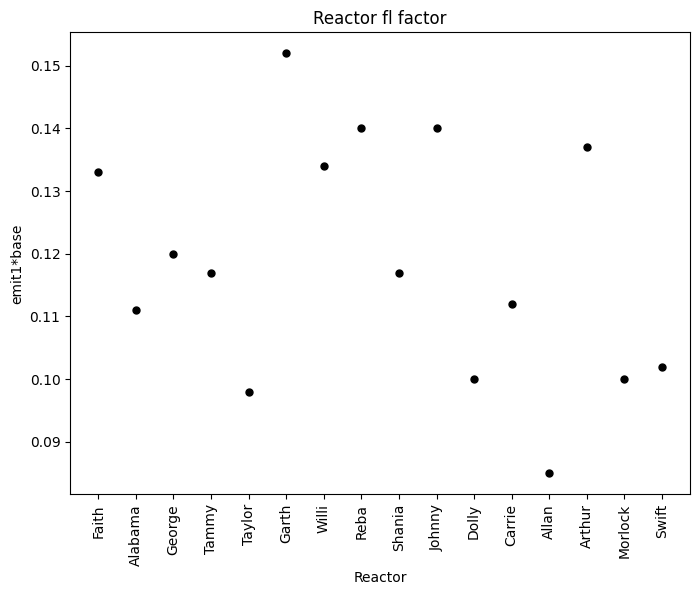

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

x = ["Faith", "Alabama", "George", "Tammy", "Taylor", "Garth", "Willi", "Reba", "Shania", "Johnny", "Dolly", "Carrie", "Allan", "Arthur", "Morlock", "Swift"]
# e = np.array([0.103*4263,0.080*3889,0.089*3960,0.082*3704,0.065*4482,0.102*3234,0.094*3599,0.095*4080,0.095*3614,0.106*3644,0.077*5116,0.087*4642,0.083*2387,0.076*1861,0.091*2072,0.098*4789])
# p = np.array([0.236*5363,0.191*4847,0.209*4868,0.199*4258,0.163*5577,0.254*3839,0.228*4469,0.235*4722,0.212*4532,0.246*4565,0.177*6070,0.199*5747,0.168*5377,0.213*4434,0.191*5421,0.200*5919])
e = np.array([0.103,0.080,0.089,0.082,0.065,0.102,0.094,0.095,0.095,0.106,0.077,0.087,0.083,0.076,0.091,0.098])
p = np.array([0.236,0.191,0.209,0.199,0.163,0.254,0.228,0.235,0.212,0.246,0.177,0.199,0.168,0.213,0.191,0.200])
matplotlib.style.use('default')
fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
ax.plot(x,p-e,'.k',markersize = 10, label = 'fl diff')
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel("emit1*base")
ax.set_xlabel("Reactor")
ax.set_title("Reactor fl factor")

(0.0, 14000.0)

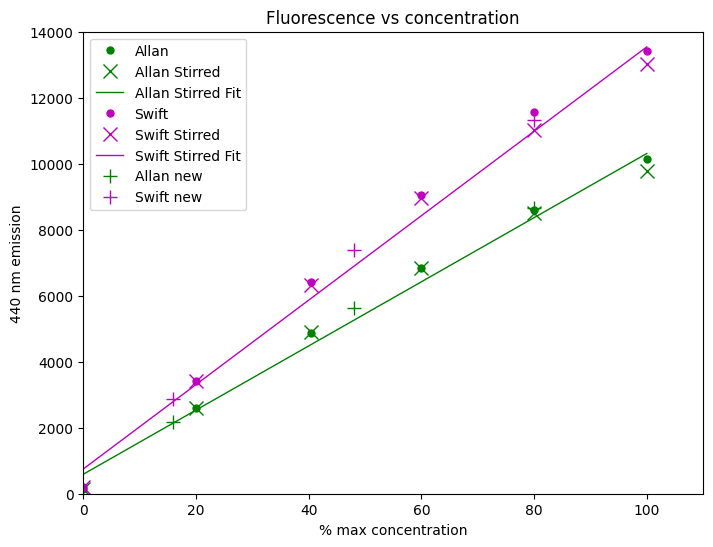

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# e = np.array([0.103*4263,0.080*3889,0.089*3960,0.082*3704,0.065*4482,0.102*3234,0.094*3599,0.095*4080,0.095*3614,0.106*3644,0.077*5116,0.087*4642,0.083*2387,0.076*1861,0.091*2072,0.098*4789])
# p = np.array([0.236*5363,0.191*4847,0.209*4868,0.199*4258,0.163*5577,0.254*3839,0.228*4469,0.235*4722,0.212*4532,0.246*4565,0.177*6070,0.199*5747,0.168*5377,0.213*4434,0.191*5421,0.200*5919])
x = [100,80,60,40.5,20,0]
em440All = np.array([[10136,9786],[8598,8516],[6828,6825],[4862,4893],[2604,2593],[129,129]])
em440Swi = np.array([[13430,13009],[11559,11022],[9039,8956],[6422,6321],[3403,3410],[208,208]])
all_model = np.poly1d(np.polyfit(x, em440All[:,1], 1))
swi_model = np.poly1d(np.polyfit(x, em440Swi[:,1], 1))
gradient = np.round(all_model.coefficients, 5)
swi_coefficients = np.round(swi_model.coefficients, 5)

x_new = [80,48,16]

em440All_new = np.array([[8648,8464],[5617,5511],[2184,2174]])
clearAll_new = np.array([[58070,50633],[36277,32884],[13317,13255]])

em440Swi_new = np.array([[11321,10945],[7393,7143],[2858,2876]])
clearSwi_new = np.array([[65535,63847],[42554,39886],[14576,15091]])

matplotlib.style.use('default')
fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
ax.plot(x,em440All[:,0],'.g',markersize = 10, label = 'Allan')
ax.plot(x,em440All[:,1],'xg',markersize = 10, label = 'Allan Stirred')
ax.plot(x,all_model(x),'g',lw=1, label = 'Allan Stirred Fit')
ax.plot(x,em440Swi[:,0],'.m',markersize = 10, label = 'Swift')
ax.plot(x,em440Swi[:,1],'xm',markersize = 10, label = 'Swift Stirred')
ax.plot(x,swi_model(x),'m',lw=1, label = 'Swift Stirred Fit')

ax.plot(x_new,em440All_new[:,0],'+g',markersize = 10, label = 'Allan new')
ax.plot(x_new,em440Swi_new[:,0],'+m',markersize = 10, label = 'Swift new')
# ax.plot(x_new,em440All_new[:,0]/clearAll_new[:,0],'og',markersize = 10, label = 'Allan em/clear')
# ax.plot(x_new,em440Swi_new[:,0]/clearSwi_new[:,0],'om',markersize = 10, label = 'Swift em/clear')
# x = ["Allan", "Swift"]
ax.set_ylabel("440 nm emission")
ax.set_xlabel("% max concentration")
ax.set_title("Fluorescence vs concentration")
ax.legend()
ax.set_xlim([0,110])
ax.set_ylim([0,14000])

In [3]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import os

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

x = [100,60,20,0]
label = ["Allan", "Arthur", "Morlock", "Swift", "Stacey", "Faith", "Alabama", "George", "Tammy", "Taylor", "Garth", "Willi", "Reba", "Shania", "Johnny", "Dolly", "Carrie"]
em440 = np.array([[4344,2655,1035,219],[4852,2956,1128,221],[5327,3275,1296,296],[5911,3660,1440,345],[3916,2422,945,227],[6097,3760,1433,235],[4645,2854,1081,170],[5097,3138,1190,190],[4045,2500,962,172],[4639,2831,1060,149],[4989,3076,1163,181],[5213,3212,1206,176],[5641,3483,1312,203],[4732,2942,1125,188],[5851,3594,1357,206],[5271,3264,1248,217],[5916,3653,1378,213]])
cl = np.array([[16159,10661,5357,3129],[14590,9683,4072,2838],[15780,10841,5747,3653],[18082,12783,6412,4028],[12808,8753,4786,2935],[14899,10014,5005,2478],[13663,9087,4597,2310],[13349,8973,4582,2344],[9799,6844,3847,2319],[14235,9590,4941,2633],[9816,6647,3511,1945],[12679,8523,4251,2089],[12174,8295,4355,2338],[11091,7569,3977,2161],[12831,8517,4319,2157],[14506,9958,5328,2992],[15854,10638,5344,2651]])

models = []
gradient = np.zeros(len(em440))
offset = np.zeros(len(em440))
for i in range(len(em440)):
    models.append(np.poly1d(np.polyfit(x, em440[i,:], 1)))
    gradient[i] = models[i].coefficients[0]
    offset[i] = models[i].coefficients[1]
med = np.median(gradient, axis = 0)
med_ind = np.where(gradient==med)[0][0]
e_fac = {label[i]: np.round(gradient[i]/med, 4) for i in range(len(em440))}
e_ofs = {label[i]: np.round((offset[i]+em440[i,-1])/2, 1) for i in range(len(em440))}
print("'e_fac' : ",e_fac)
print("'e_ofs' : ",e_ofs)

cmap = cm.get_cmap('rainbow', len(em440)) # rainbow colormap
x_pos = np.arange(len(em440))
x_mod = np.arange(0,100,0.1)
matplotlib.style.use('default')
fig, [ax, ax2] = plt.subplots(2,2)
fig.set_figheight(14)
fig.set_figwidth(18)
for i in range(len(em440)):
    a = 1
    if i%2 == 0:
        a = 0.1
    ax[0].plot(x,em440[i,:],'--x',markersize = 5, label = label[i], color = cmap(i),alpha = a)
    ax[0].plot(x_mod,models[i](x_mod),'-',lw=1, color = cmap(i),alpha = a)
    ax[1].plot(x,cl[i,:],'--x',markersize = 5, label = label[i], color = cmap(i))
    ax2[0].bar(label[i],e_fac[label[i]],color = cmap(i))
    ax2[1].bar(i,offset[i],width = 0.4,color = cmap(i))
    ax2[1].bar(i+0.4,em440[i,-1],width = 0.4,color = lighten_color(cmap(i),1.5))
    # ax.plot(x,models[i](x),'-',lw=1)

ax[0].set_ylabel("Intensity")
ax[0].set_xlabel("% max Concentration")
ax[0].set_title("440nm Emission vs. Concentration")
ax[0].legend()
ax[0].set_xlim([0,110])
ax[0].set_ylim([0,7000])
ax[1].set_ylabel("Intensity")
ax[1].set_xlabel("% max concentration")
ax[1].set_title("Clear Filter Emission vs. Concentration")
ax[1].legend()
ax[1].set_xlim([0,110])
ax[1].set_ylim([0,20000])
ax2[0].set_xlabel("Reactor")
ax2[0].set_title("Relative 440nm Fluorescence Factor")
ax2[0].set_xticklabels(label, rotation=90)
ax2[0].get_xticklabels()[med_ind].set_color(cmap(med_ind))
ax2[1].set_xticks(x_pos + 0.2, label)
ax2[1].set_xticklabels(label, rotation=90)
ax2[1].set_title("440nm Offset")
ax2[1].set_xlabel("Reactor")
ax2[1].legend(["Line Offset","Measured Intensity at 0%"])
plt.tight_layout()

results_dir = "Images/{}".format("077-2")
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir+"/analysis_fl_factor.png",transparent=True)
# Do not show plot
plt.close()

'e_fac' :  {'Allan': 0.8406, 'Arthur': 0.9445, 'Morlock': 1.0252, 'Swift': 1.1362, 'Stacey': 0.7536, 'Faith': 1.1945, 'Alabama': 0.9118, 'George': 1.0, 'Tammy': 0.7893, 'Taylor': 0.9146, 'Garth': 0.98, 'Willi': 1.0267, 'Reba': 1.1088, 'Shania': 0.9263, 'Johnny': 1.1502, 'Dolly': 1.0304, 'Carrie': 1.1627}
'e_ofs' :  {'Allan': 214.4, 'Arthur': 213.8, 'Morlock': 291.9, 'Swift': 339.3, 'Stacey': 221.4, 'Faith': 241.2, 'Alabama': 173.5, 'George': 194.4, 'Tammy': 175.7, 'Taylor': 151.1, 'Garth': 186.2, 'Willi': 181.9, 'Reba': 208.9, 'Shania': 196.1, 'Johnny': 210.9, 'Dolly': 222.4, 'Carrie': 219.6}


/var/folders/rm/n2qcx4x93h38srcvnc91v39w0000gn/T/ipykernel_2263/3675255151.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', len(em440)) # rainbow colormap
/var/folders/rm/n2qcx4x93h38srcvnc91v39w0000gn/T/ipykernel_2263/3675255151.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2[0].set_xticklabels(label, rotation=90)


In [1]:
import numpy as np
from run import CbData
from paramsData import CbDataParam
from config.params import Params

# SPECIFY DATA
data_name = '075-1'
cbParam = CbDataParam(data_name)
sampcycle = cbParam.sampcycle.copy()
cbParam.sampcycle = np.array([[0,1800] for i in range(cbParam.n_reactors)])
cbData = CbData(cbParam.path, cbParam.file_ind, cbParam.sampcycle, cbParam.n_reactors)
parameters = Params().default

diluting = False
od_h = 0
start_ind = 0
od_dif = []
dil_ind = []
for j in range(cbParam.n_reactors):
    for i in range(len(cbData.time[j])):
        if cbData.dil[j][i] and not cbData.dil[j][max(0,i-1)]:
            od_h = cbData.od[j][i]
            start_ind = i
            diluting = True
        if not cbData.dil[j][i] and diluting:
            if i - start_ind > 1:
                od_dif.append(od_h - cbData.od[j][i])
                dil_ind.append(int(i - start_ind))
            diluting = False
dil_am = np.mean(od_dif)
dil_r = np.mean(dil_ind)
print(dil_am)
print(dil_r)
print(dil_am/dil_r)


cb_fc_ec information of 075-1 not given.
0.11508732956330299
2.3804878048780487
0.04834611180425638
